In [3]:
from IPython.display import HTML

# REINFORCE on 4x4 empty maze

/home/zuo/anaconda3/envs/RL/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


None
[Episode #  1]: 
 		Total loss: -0.919200		Batch episodic rewards: -2.280000
[Episode #100]: 
 		Total loss: 5.031993		Batch episodic rewards: -3.110000
[Episode #200]: 
 		Total loss: 0.037855		Batch episodic rewards: -0.090000
[Episode #300]: 
 		Total loss: -0.339151		Batch episodic rewards: -0.090000
[Episode #400]: 
 		Total loss: 0.038850		Batch episodic rewards: -0.090000
[Episode #500]: 
 		Total loss: -2.492527		Batch episodic rewards: -0.090000
[Episode #600]: 
 		Total loss: -0.403864		Batch episodic rewards: 0.910000
[Episode #700]: 
 		Total loss: -0.981626		Batch episodic rewards: 0.910000
[Episode #800]: 
 		Total loss: -1.791194		Batch episodic rewards: 0.910000
[Episode #900]: 
 		Total loss: -2.166388		Batch episodic rewards: 0.910000
[Episode #1000]: 
 		Total loss: -4.470533		Batch episodic rewards: -0.090000


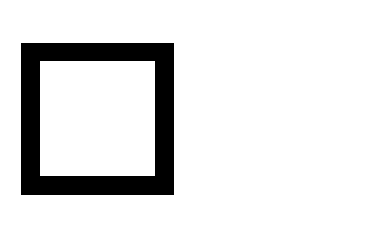

In [81]:
import gym

from Gym_GridWorld.envs import GridWorldEnv
from Gym_GridWorld.envs import RandomGridGenerator

import numpy as np

import argparse

import torch
import torch.optim as optim

from REINFORCE import REINFORCEAgent
from policies import MLPPolicy, MLPGoalPolicy, MLPValuePolicy
from runner import Runner

# Parse hyperparameters from command line
parser = argparse.ArgumentParser(description='REINFORCE')
parser.add_argument('--lr', type=float, default=1e-2, 
                    help='learning rate (default: 1e-2)')
parser.add_argument('--gamma', type=float, default=0.99, 
                    help='discount factor (default: 0.99)')
parser.add_argument('--seed', type=int, default=543, 
                    help='random seed (default: 543)')
parser.add_argument('--render', action='store_true', 
                    help='render the environment')
parser.add_argument('--log-interval', type=int, default=10, 
                    help='interval between training status logs (default: 10)')

parser.add_argument('--goal_policy', action='store_true', 
                    help='use goal-conditional policy')

parser.add_argument('--init_state', nargs='+', type=int,
                    help='set initial state')
parser.add_argument('--goal_states', nargs='+', type=int,
                    help='set goal states')

#args = parser.parse_args()
str_cmd = '--lr 1e-3 --gamma 0.99 --log-interval 100 ' \
        ' --seed 789' \
        ' --init_state 1 1 --goal_states 6 6' \
        ' --goal_policy'
args = parser.parse_args(str_cmd.split())  # in Notebook

# Create environment
randomgrid = RandomGridGenerator(grid_size=6, obstacle_ratio=0.0)
env = GridWorldEnv(randomgrid, trace=False)
env.init_state = args.init_state
env.goal_states = [args.goal_states]

# Set random seed
env.seed(args.seed)
torch.manual_seed(args.seed)    

        
def main():
    #######
    # TODO: General class, deal with both discrete and continuous
    #######
    # Create environment specification
    env_spec = {}
    env_spec['input_dim'] = int(np.prod(env.observation_space.shape))
    env_spec['action_dim'] = env.action_space.n
    # Create a policy network
    if args.goal_policy:
        env_spec['goal_dim'] = np.array(env.goal_states).reshape(-1).shape[0]
        policy = MLPGoalPolicy(env_spec, 64)
    else:
        policy = MLPPolicy(env_spec, 64)
    
    # Create an optimzer
    optimizer = optim.Adam(policy.parameters(), lr=args.lr)
    # Create an agent
    agent = REINFORCEAgent(policy, optimizer)
    # Create a Runner
    runner = Runner(agent, env, args.gamma)
    
    print(env.unwrapped.state)
    
    # Loggings
    log_epi_rewards = []
    
    for epi in range(1000):
        # Collect batch of data via runner
        data_batch = runner.run(30, 1)
        # Train agent over batch of data
        losses = agent.train(data_batch, normalize_r=True)
        
        epi_rewards = np.sum(data_batch[0]['rewards'])
        log_epi_rewards.append(epi_rewards)
        
        if epi == 0 or (epi + 1)%args.log_interval == 0:    
            log_str = '[Episode #{:3d}]: \n '\
                        '\t\tTotal loss: {:f}'\
                        '\t\tBatch episodic rewards: {:f}'
            print(log_str.format(epi + 1, losses['total_loss'].data[0], epi_rewards))
    
    if args.goal_policy:
        log_str = './logs/REINFORCE_goalpolicy_{:d}'
    else:
        log_str = './logs/REINFORCE_policy_{:d}'
    np.save(log_str.format(args.seed), log_epi_rewards)
    
if __name__ == '__main__':
    main()

# REINFORCE in CartPole-v0

In [77]:
import gym
import numpy as np

import argparse

import torch
import torch.optim as optim

from REINFORCE import REINFORCEAgent
from policies import MLPPolicy
from runner import Runner

# Parse hyperparameters from command line
parser = argparse.ArgumentParser(description='REINFORCE')
parser.add_argument('--lr', type=float, default=1e-2, 
                    help='learning rate (default: 1e-2)')
parser.add_argument('--gamma', type=float, default=0.99, 
                    help='discount factor (default: 0.99)')
parser.add_argument('--seed', type=int, default=543, 
                    help='random seed (default: 543)')
parser.add_argument('--render', type=bool, default=False, 
                    help='render the environment (default: False)')
parser.add_argument('--log-interval', type=int, default=10, 
                    help='interval between training status logs (default: 10)')
#args = parser.parse_args()
args = parser.parse_args('--lr 1e-2 --gamma 0.99 --seed 543 --render True --log-interval 10'.split())  # in Notebook

# Create environment
env = gym.make('CartPole-v0')

# Set random seed
env.seed(args.seed)
torch.manual_seed(args.seed)    

        
def main():
    #######
    # TODO: General class, deal with both discrete and continuous
    #######
    # Create environment specification
    env_spec = {}
    env_spec['input_dim'] = int(np.prod(env.observation_space.shape))
    env_spec['action_dim'] = env.action_space.n
    # Create a policy network
    policy = MLPPolicy(env_spec, 128)
    # Create an optimzer
    optimizer = optim.Adam(policy.parameters(), lr=args.lr)
    # Create an agent
    agent = REINFORCEAgent(policy, optimizer)
    # Create a Runner
    runner = Runner(agent, env, args.gamma)
    
    # Loggings
    log_epi_rewards = []
    
    for epi in range(1000):
        # Collect batch of data via runner
        data_batch = runner.run(300, 1)
        # Train agent over batch of data
        losses = agent.train(data_batch, normalize_r=True)
        
        epi_rewards = np.sum(data_batch[0]['rewards'])
        log_epi_rewards.append(epi_rewards)
        
        if epi == 0 or (epi + 1)%args.log_interval == 0:    
            log_str = '[Episode #{:3d}]: \n '\
                        '\t\tTotal loss: {:f}'\
                        '\t\tBatch episodic rewards: {:f}'
            print(log_str.format(epi + 1, losses['total_loss'].data[0], epi_rewards))
            
    np.save('./logs/REINFORCE_{:d}'.format(args.seed), log_epi_rewards)
    
if __name__ == '__main__':
    main()

/home/zuo/anaconda3/envs/RL/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


[Episode #  1]: 
 		Total loss: 0.544309		Batch episodic rewards: 12.000000
[Episode # 10]: 
 		Total loss: 0.236842		Batch episodic rewards: 9.000000
[Episode # 20]: 
 		Total loss: -0.535106		Batch episodic rewards: 12.000000
[Episode # 30]: 
 		Total loss: -2.852829		Batch episodic rewards: 9.000000
[Episode # 40]: 
 		Total loss: 1.080271		Batch episodic rewards: 11.000000
[Episode # 50]: 
 		Total loss: 1.035599		Batch episodic rewards: 29.000000
[Episode # 60]: 
 		Total loss: 2.183445		Batch episodic rewards: 75.000000
[Episode # 70]: 
 		Total loss: -3.177142		Batch episodic rewards: 63.000000
[Episode # 80]: 
 		Total loss: 2.128655		Batch episodic rewards: 165.000000
[Episode # 90]: 
 		Total loss: 3.480616		Batch episodic rewards: 75.000000
[Episode #100]: 
 		Total loss: -3.122817		Batch episodic rewards: 78.000000
[Episode #110]: 
 		Total loss: 1.761564		Batch episodic rewards: 200.000000
[Episode #120]: 
 		Total loss: -5.297289		Batch episodic rewards: 69.000000
[Episod

In [4]:
np.concatenate([np.array([1, 2, 3]), np.array([5, 6])])

array([1, 2, 3, 5, 6])

# Actor-Critic in CartPole-v0

In [43]:
import gym
import numpy as np

import argparse

import torch
import torch.optim as optim

from ActorCritic import ActorCriticAgent
from policies import MLPValuePolicy
from runner import Runner

# Parse hyperparameters from command line
parser = argparse.ArgumentParser(description='Actor-Critic')
parser.add_argument('--gamma', type=float, default=0.99, 
                    help='discount factor (default: 0.99)')
parser.add_argument('--seed', type=int, default=543, 
                    help='random seed (default: 543)')
parser.add_argument('--render', type=bool, default=False, 
                    help='render the environment (default: False)')
parser.add_argument('--log-interval', type=int, default=10, 
                    help='interval between training status logs (default: 10)')
#args = parser.parse_args()
args = parser.parse_args('--gamma 0.99 --seed 543 --render True --log-interval 10'.split())  # in Notebook

# Create environment
env = gym.make('CartPole-v0')

# Set random seed
env.seed(args.seed)
torch.manual_seed(args.seed)    

        
def main():
    # Create a policy network
    policy = MLPValuePolicy()
    # Create an optimzer
    optimizer = optim.Adam(policy.parameters(), lr=3e-2)
    # Create an agent
    agent = ActorCriticAgent(policy, optimizer)
    # Create a Runner
    runner = Runner(agent, env, args.gamma)
    
    # Loggings
    log_epi_rewards = []
    
    for epi in range(1000):
        # Collect batch of data via runner
        data_batch = runner.run(300, 1)
        # Train agent over batch of data
        losses = agent.train(data_batch, normalize_r=True)
        
        epi_rewards = np.sum(data_batch[0]['rewards'])
        log_epi_rewards.append(epi_rewards)        

        if epi == 0 or (epi + 1)%args.log_interval == 0:
            log_str = '[Episode #{:3d}]: \n '\
                        '\t\tTotal loss: {:f}'\
                        '\t\tBatch episodic rewards: {:f}'
            print(log_str.format(epi + 1, losses['total_loss'].data[0], epi_rewards))
            
    np.save('./logs/AC_3', log_epi_rewards)
    
if __name__ == '__main__':
    main()

[Episode #  1]: 
 		Total loss: 5.728110		Batch episodic rewards: 13.000000
[Episode # 10]: 
 		Total loss: 1.267938		Batch episodic rewards: 10.000000
[Episode # 20]: 
 		Total loss: 0.165668		Batch episodic rewards: 9.000000
[Episode # 30]: 
 		Total loss: 0.962518		Batch episodic rewards: 12.000000
[Episode # 40]: 
 		Total loss: 114.847397		Batch episodic rewards: 110.000000
[Episode # 50]: 
 		Total loss: 34.642334		Batch episodic rewards: 86.000000
[Episode # 60]: 
 		Total loss: 13.807370		Batch episodic rewards: 98.000000
[Episode # 70]: 
 		Total loss: 18.208549		Batch episodic rewards: 200.000000
[Episode # 80]: 
 		Total loss: 25.526546		Batch episodic rewards: 65.000000
[Episode # 90]: 
 		Total loss: 18.681656		Batch episodic rewards: 58.000000
[Episode #100]: 
 		Total loss: 78.446220		Batch episodic rewards: 177.000000
[Episode #110]: 
 		Total loss: 43.183044		Batch episodic rewards: 200.000000
[Episode #120]: 
 		Total loss: 65.056793		Batch episodic rewards: 200.00000

# Visualization of learning dynamics
### Average over different random seeds

/home/zuo/anaconda3/envs/RL/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


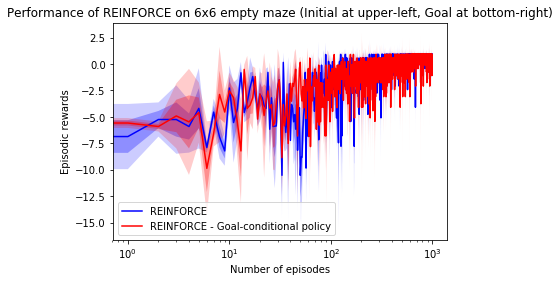

In [82]:
import numpy as np
from plotter import Plotter

from glob import glob  # matching pathnames with patterns

plotter = Plotter()

scales = [0.5, 1.0]
alphas = [0.3, 0.2]

data = []
for filepath in glob('logs/REINFORCE_policy*.npy'):
    data.append(np.load(filepath))
plotter.add_curve(data, 
                  color='blue', 
                  label='REINFORCE', 
                  uncertainty=True, 
                  scales=scales, 
                  alphas=alphas)

data = []
for filepath in glob('logs/REINFORCE_goalpolicy*.npy'):
    data.append(np.load(filepath))
plotter.add_curve(data, 
                  color='red', 
                  label='REINFORCE - Goal-conditional policy', 
                  uncertainty=True, 
                  scales=scales, 
                  alphas=alphas)

title = 'Performance of REINFORCE on 6x6 empty maze (Initial at upper-left, Goal at bottom-right)'
xlabel = 'Number of episodes'
ylabel = 'Episodic rewards'
fig = plotter.plot(title, xlabel, ylabel, log_x=True)
fig.show()

fig.savefig('logs/tmp.png')